
##  **Final Assignment**

The final assignment intends to summarize and compare the concepts and methods taught throughout the course. We will use a
 very simple task where the ground truth (optimal policies and value functions) are easy to establish and we will
 implement and evaluate the performance of some of the most important algorithms in solving the MDP. This task is called `Circle World`.

# Circle world

Consider an agent navigating a *circular environment*, consisting of a simple circular track divided into `n_states`.
 From any state, the agent may choose to step `left` or `right`. All actions lead to a reward $-1/(N-1)$, where $N=$ n_states -1, except for
 actions that lead the agent to the target state 0 which receive a reward of +1. States 0 and $N$ are connected to
 form a circle and the agent is randomly placed in the Circle (i.e. random initial state).

![](https://raw.githubusercontent.com/yuzhenqin90/RLcourse/main/final/CircleWorldMDP.png)

We will consider two variants of the task: an **episodic** version where 0 is a terminal state and a **continuing**
version where there is no terminal state and the agent can just move indefinitely around the circle.

The final assignment is built on this simple task--Circle World. It contains four parts, emcompassing all the content taught in the course:
 1. Markov Decision Processes (*1 Points*)
 2. Dynamic Programming (*4 Points*)
 3. Monte Carlo methods (*2 Points*)
 4. TD-learning (*3 Points*)

# Sofie Vos

---
#### Requirements

In [850]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

---

#### Preliminaries

Let's start by defining a generic environment base class.

**NOTE:** For simplicity and to make sure you are always able to run the exercises, we provide a simple
implementation in Python / numpy. You are encouraged to re-implement the MDP below using `gymnasium` (up to 2 bonus points,
 to a maximum final grade of 10, will be awarded if you do).

In [851]:
class CircleWorld():
	"""
	Generic base class for MDPs with finite s, action and reward spaces
	"""
	def __init__(self, n_states, n_actions, reward, task, gamma=1.0, state_labels=None, action_labels=None):
		"""
		n_states: number of states [0,...,N-1]
		n_actions: number of actions [0,...,N-1]
		reward: reward values
		task: episodic or continuing
		gamma: discounting factor
		"""
		self.n_states = n_states
		self.n_actions = n_actions
		self.state_labels = state_labels or np.arange(self.n_states)
		self.action_labels = action_labels or np.arange(self.n_actions)
		self.n_rewards = len(reward)
		self.reward = reward
		assert(task == 'episodic' or task == 'continuing')
		self.task = task
		self.gamma = gamma

	def reset(self):
		"""
		Sample initial state at start of the episode; assumed uniform
		"""
		return np.random.randint(self.n_states)

	def p_transition(self, s, a, s1, r):
		"""
		Transition density s x a => s1 x r
		"""
		# This only works for deterministic state transitions; otherwise override
		return np.float64((s1, r) == self.step(s, a))

	def step(self, s, a):
		"""
		Sample new state and reward when starting in s and taking action a
		:return new_state, reward_index: note that there are 3
		"""
		s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
		if s1 == 0:
			r = 0
		else:
			r = 1
		return s1, r

	def sample_action(self, state, policy):
		# sample action from policy for a given state
		return np.random.choice(np.arange(self.n_actions), p=policy[state])

	def sample_episode(self, policy, T=None):
		"""
		Sample a finite horizon sequence from an MDP using some policy
		If the tasks is continuing then we sample exactly T steps
		If the task is episodic then we sample exactly one episode or reset until we sample T steps
		"""
		# sequence element is state, action, reward
		seq = []
		# randomly sample initial state NOTE: For exploring starts we would need to sample both states and actions. This is not needed for epsilon-greedy policies
		s = self.reset()

		if self.task == 'continuing':
			assert (T is not None)
			for t in range(T):
				a = self.sample_action(s, policy)
				(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
		else:
			t = 0
			while True:

				if T is None and self.is_terminal(s):
					break
				elif t == T:
					break

				a = self.sample_action(s, policy)
				if self.is_terminal(s):
					s1 = self.reset()
					r = 0
				else:
					(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
				t = t+1
		return seq

	def optimal_policy(self):
		"""
		For this simple task, the optimal policy is just to move to state zero as quickly as possible
		and then flip back and forth
		"""
		policy = np.zeros([self.n_states, self.n_actions])
		n = int(np.round(self.n_states/2))
		policy[:n, 0] = 1.0
		policy[n:, 1] = 1.0
		policy[self.terminal_states(), :] = 1.0 / self.n_actions
		return policy

	def random_deterministic_policy(self):
		"""
		Random choice of a deterministic action for each state
		"""
		return np.random.multinomial(1, [1.0 / self.n_actions for a in range(self.n_actions)], self.n_states).astype('float32')

	def nonterminal_states(self):
		"""
		:return: The set S of nonterminal states
		"""
		return [s for s in range(self.n_states) if not self.is_terminal(s)]

	def terminal_states(self):
		"""
		:return: The set S of terminal states
		"""
		return [s for s in range(self.n_states) if self.is_terminal(s)]

	def is_terminal(self, s):
		"""
		flags if s is a terminal state
		"""
		if self.task == "episodic":
			return s == 0
		else:
			return False

	def q_to_v(self, q, policy):
		"""
		Convert Q-value to state value
		:param q:
		:param policy:
		:return:
		"""
		v = np.zeros(self.n_states)
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				v[s] += policy[s, a] * q[s, a]
		return v

	def v_to_q(self, v):
		"""
		Convert state value to Q-value
		:param v:
		:return:
		"""
		q = np.zeros([self.n_states, self.n_actions])
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				q[s, a] = sum(self.p_transition(s, a, s1, r) * (self.reward[r] + self.gamma * v[s1])
				              for s1 in range(self.n_states) for r in range(self.n_rewards))
		return q

	# some simple rendering methods
	def __str__(self):
		str = "task: {0}\n".format(self.task)
		str += "states: {0}\n".format(self.state_labels)
		if self.terminal_states():
			str += "terminal states: {0}\n".format(self.terminal_states())
		str += "actions: {0}\n".format(self.action_labels)
		str += "rewards: {0}\n".format(self.reward)
		str += "discounting factor: {0}".format(self.gamma)
		return str

	def print_policy(self, policy):
		for s in range(self.n_states):
			a = np.random.choice(np.arange(self.n_actions), p=policy[s])
			print('state ' + str(self.state_labels[s]) + ' => action ' + str(self.action_labels[a]))

	def print_value(self, vf):
		"""
		:param vf: state value or action value function
		"""
		if vf.ndim == 1:
			for s in range(self.n_states):
				print('state ' + str(self.state_labels[s]) + ': ' + str(vf[s]))
		else:
			for s in range(self.n_states):
				for a in range(self.n_actions):
					print('state ' + str(self.state_labels[s]) + ' - action ' + str(self.action_labels[a] + ': ' + str(vf[s,a])))

In [852]:
# For implementation in gym
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CircleWorldGym(gym.Env):
    def __init__(self, n_states, n_actions, reward, task, gamma=1.0):
        self.n_states = n_states
        self.n_actions = n_actions
        self.reward = reward
        self.task = task
        self.gamma = gamma
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.Discrete(n_states)
        self.state_labels = np.arange(n_states)
        self.action_labels = np.arange(n_actions)
        self.reset()
    
    def reset(self):
        self.state = np.random.randint(self.n_states)
        return self.state
    
    def step(self, action):
        s = self.state
        s1, r = self._transition(s, action)
        self.state = s1
        
        done = self._is_terminal(s1)
        
        return s1, self.reward[r], done, {}
    
    def _transition(self, s, a):
        s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
        if s1 == 0:
            r = 0
        else:
            r = 1
        return s1, r
    
    def _is_terminal(self, s):
        if self.task == "episodic":
            return s == 0
        else:
            return False
        
    def render(self, mode='human'):
        pass  # implement a visualization

    def close(self):
        pass  # clean up resources?

    # add other functions from CircleWorld class if needed

To evaluate longer episodes, we will primarily use the continuing version and specify a maximum timespan $T$ where we
manually stop the simulation. Depending on the class of algorithms and their specificities, we will alternate between
 the continuing and episodic versions of the task.

In [853]:
mdpc = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='continuing', gamma=0.99,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpc)

mdpe = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1.,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpe)

task: continuing
states: [0 1 2 3 4 5 6 7 8 9]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 0.99
task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 1.0


Given the simplicity of the task, the optimal policy simply requires moving to state 0 as quickly as possible, so we
can construct an explicit optimal policy which will be used as baseline for comparisons and performance evaluations:

In [854]:
# to understand the policy, study the `optimal_policy` method defined above
pi_optimal_c = mdpc.optimal_policy()
mdpc.print_policy(pi_optimal_c)

state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


In [855]:
pi_optimal_e = mdpe.optimal_policy()
pd.DataFrame({"p(L|s)": pi_optimal_e[:,0], "p(R|s)": pi_optimal_e[:,1]})
mdpe.print_policy(pi_optimal_e)

state 0 => action R
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


Having this ground truth ($\pi_{*}$, $v_{*}$ and $q_{*}$) we can evaluate how accurate are the corresponding estimates
 from the different algorithms ($\hat{\pi}$, $V(s)$ and $Q(s,a)$) by determining the mean-squared error between
 the. For example, having an estimate of $V$, the distance between this estimate and the true value function is given
  by:

$$MSE(V, v_{\pi}) = \sum_{s} (V(s) - v_{\pi}(s))^{2}$$

This way of measuring the accuracy of the estimates will be used throughout the assignment.

---

## 1. Markov Decision Processes *(1 point)*

**a**) Define a uniform / equiprobable stochastic policy (all actions have equal probability in all states). Note
that a policy in the current implementation should be defined as an [`n_states` x `n_actions`] array. ---------(**0.2 point**)

The cell below
illustrates an example deterministic policy :

In [856]:
example_policy = mdpc.random_deterministic_policy()
pol = pd.DataFrame({"p(L|s)": example_policy[:,0], "p(R|s)": example_policy[:,1]})
pol

,p(L|s),p(R|s)
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,0.0,1.0
8,1.0,0.0
9,0.0,1.0


In [857]:
def uniform_stochastic_policy(n_states, n_actions):
	"""
	Each action has equal probability in all states
	"""
	return np.ones((n_states, n_actions)) / n_actions

**b**) Sample an "episode" from the MDP (use `mdpc`, but cut-off the simulation at 500 timesteps), under the uniform
stochastic policy you defined above and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. Note that the sample episode is a sequence of `[state, action,
reward]`, so the returns have to be calculated from the rewards obtained. ---------(**0.2 point**)

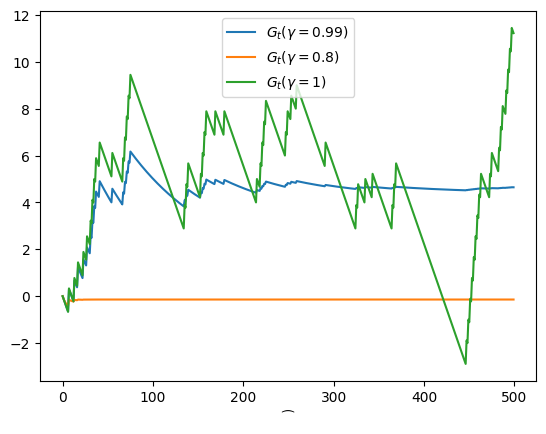

In [858]:
def calc_returns_G(seq_of_r, discount_factor):
    """
    Calculates the cumulative returns
	"""

    returns_G = []
    #what G we calculate
    for t in range(0, len(seq_of_r)):
        G_t = 0
        discount_exp = 0
        #loop over the needed rewards
        for r_index in range(0, t):
            G_t += seq_of_r[r_index] * (discount_factor**discount_exp)
            discount_exp += 1
        returns_G.append(G_t)

    return returns_G

def calc_returns_G_and_plot(sequence):
    returns_discount_1 = calc_returns_G([r for _, _, r in sequence], 1)
    returns_discount_099 = calc_returns_G([r for _, _, r in sequence], 0.99)
    returns_discount_08 = calc_returns_G([r for _, _, r in sequence], 0.8)

    t = np.arange(0., len(sequence), 1.)
    plt.plot(t, returns_discount_099, label=r'$G_t(\gamma = 0.99)$')
    plt.plot(t, returns_discount_08, label=r'$G_t(\gamma = 0.8)$')
    plt.plot(t, returns_discount_1, label=r'$G_t(\gamma = 1)$')
    plt.xlabel(r'$\t$')
    plt.legend()
    plt.show()

sequence = mdpc.sample_episode(uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions), 500)
calc_returns_G_and_plot(sequence)

**c**) What is the problem of using $\gamma=1$ for this task? How was this problem solved in **b**? ---------(**0.2 point**)

Using $\gamma=1$ will give the expected return of a very farsighted agent. But the agent of this continous task should not be extremely farsighted as the task will never terminate. If the task is not cut off like we did, the value of the expected return never converges.
So we fixed the problem by cutting off the episode, making it terminate.

**d**) Sample an episode from the episodic version of the task (implemented above as `mdpe`), under the uniform
stochastic policy
and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. ---------(**0.2 point**)

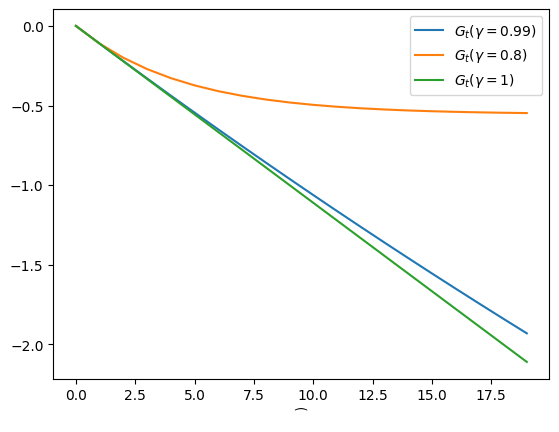

In [859]:
sequence = mdpe.sample_episode(uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions))
calc_returns_G_and_plot(sequence)

**e**) Rerun the continuing task with a fixed $T=500$, using the pre-implemented deterministic policy and plot the
evolution of the returns $G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$.
---------(**0.2 point**)

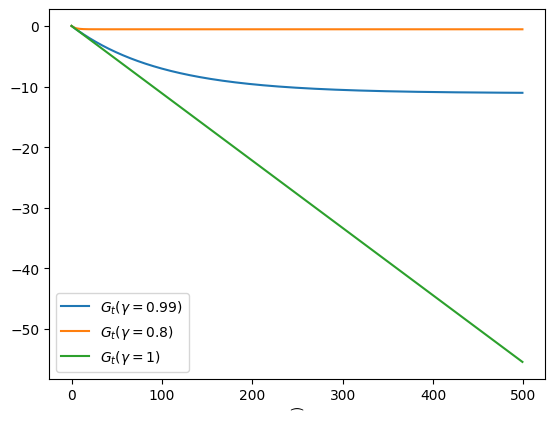

In [860]:
sequence = mdpc.sample_episode(mdpc.random_deterministic_policy(), 500)
calc_returns_G_and_plot(sequence)

### 2. Dynamic Programming *(4 points)*


**a**) **Policy evaluation**: DP-prediction

**a.1**) Write a policy evaluation function, which computes the state-value function from a given policy, $v_{\pi}$. ---------(**1 point**)

In [861]:
def policy_evaluation(mdp, policy, theta=1e-8, V=None, max_t=float('inf')):
	"""
	Iterative policy evaluation
	:param mdp: the mdp object
	:param policy: the policy to evaluate
	:param value: the value function (can be initialized)
	:param theta: cutoff for policy evaluation
	:param max_t: maximum number of steps
	Returns: State value function V
	"""
	# Conditions for convergence
	assert (mdp.task == 'episodic' or mdp.gamma < 1.0)
	# Init V
	if V is None:
		V = np.zeros(mdp.n_states)

	# Evaluate policy iteratively
	t = 0
	while True:
		delta = 0
		# Iterate through each state
		for s in range(mdp.n_states):
			v = 0
			# Try all possible actions which can be taken from this state
			for a, a_prob in enumerate(policy[s]):
				if(((not mdp.is_terminal(s) and mdp.task == 'episodic') or not mdp.task == 'episodic')):
					s1, r_index = mdp.step(s, a)
					v += a_prob * mdp.p_transition(s, a, s1, r_index) * (mdp.reward[r_index] + mdp.gamma * V[s1])
			# Calculate the absolute change of value function
			delta = max(delta, np.abs(V[s] - v))
			# Update value function
			V[s] = v
			t += 1

		if t > max_t or delta < theta:
			# print(f'Policy evaluated in {t} iterations.')
			return V

**a.2**) Evaluate the optimal policy generated above, using the `policy_evaluation` function you just implemented.
Compare the value function ($v_{\pi}$) for the optimal policy with that obtained for the deterministic random policy
(pre-implemented) and for the stochastic, uniform random policy you implemented in 1a). Print or plot the results. ---------(**0.4 point**)

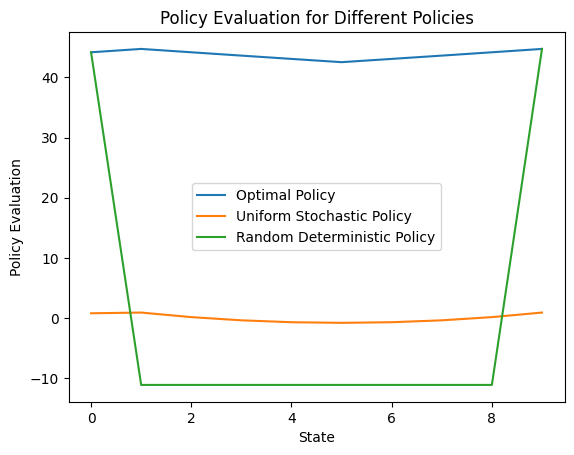

In [862]:
# episodic for random deterministic policy took too long so I use the continous task
x = np.arange(0, mdpc.n_states)
plt.plot(x, policy_evaluation(mdpc, mdpc.optimal_policy()), label='Optimal Policy')
plt.plot(x, policy_evaluation(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions)), label='Uniform Stochastic Policy')
plt.plot(x, policy_evaluation(mdpc, mdpc.random_deterministic_policy()), label='Random Deterministic Policy')

plt.xlabel('State')
plt.ylabel('Policy Evaluation')
plt.title('Policy Evaluation for Different Policies')
plt.legend()
plt.show()



**a.3**) Evaluate the optimal policies for the continuing and the episodic tasks and plot the resulting value
functions $v_{*}$. What is the main difference in state values? Why is this the case? ---------(**0.4 point**)

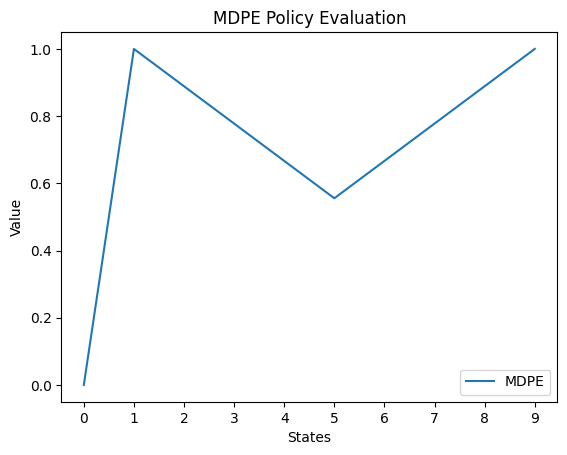

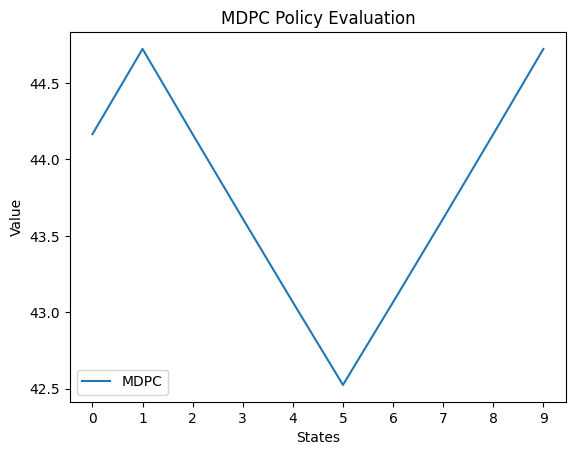

In [863]:
def plot_state_values_optimal_policies(mdp, label_mdp):
    x = np.arange(0, mdpc.n_states, 1)
    plt.plot(x, policy_evaluation(mdp, mdp.optimal_policy()), label=label_mdp)
    plt.xlabel('States')
    plt.ylabel('Value')
    plt.title(label_mdp +' Policy Evaluation')

    plt.xticks(np.arange(min(x), max(x)+1, 1)) 
    plt.legend()
    plt.show()

plot_state_values_optimal_policies(mdpe, 'MDPE')
plot_state_values_optimal_policies(mdpc, 'MDPC')

The state values for the episodic task are way lower than the state values of the continous task, because of the existence of a terminal state in the episodic task. In the episodic task, the reward of the terminal state is +1 (and then the episode stops), but all the other states give a negative reward. With the continous task, the agent doesn't receive a final positive reward, but it also doesn't receive any negative rewards for continuing to move. <br>
 Since the number of states with negative rewards outweighs the single state with a positive reward, the episodic task tends to yield lower state values. And since in the contionous task there is no final positive reward, the absence of negative rewards for continued movement allows the agent to accumulate higher state values over time.

**b**) **Policy iteration** versus **value iteration**: DP-control

The control problem is solved by following a sequence of policy *evaluation* and *improvement*:

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{0}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{1}
\stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{1}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{2}
\stackrel{\mathrm{E}}{\longrightarrow} \cdots \stackrel{\mathrm{I}}{\longrightarrow} \pi_{*}
\stackrel{\mathrm{E}}{\longrightarrow} v_{*}$$

In the exercise above, we have implemented the `policy_evaluation` step, which, given a policy $\pi$, returns the
corresponding state value function $v_{\pi}$.


**b.1**) Implement a `policy_improvement` function
where, given a policy and a state value function, computes action-values $q_{\pi}$ and uses those to improve the
policy by selecting the actions with the highest $q_{\pi}$ for every given state, i.e. acting greedy with respect to
the Q-values to improve the policy. ---------(**1 point**)

In [864]:
def one_step_lookahead(mdp, s, V, policy):
	"""
    Performs a one-step lookahead for each action from a given state in a Markov Decision Process.
	"""
	a_values = np.zeros(mdp.n_actions)
	for a in range(mdp.n_actions):
		for s1 in range(mdp.n_states):
			for r_index, r in enumerate(mdp.reward):
				a_values[a] += mdp.p_transition(s, a, s1, r_index) * (r + mdp.gamma * V[s1])	
	return a_values

def policy_improvement(mdp, policy, V):
	"""
	Policy improvement operates directly on the input policy.
	:param mdp: the mdp object
	:param policy: the policy to improve
	:param V: state-value function
	returns: policy, policy_stable (bool)
	"""
	policy_stable = True
	# Go through each state and try to improve actions that were taken (policy Improvement)
	for s in range(mdp.n_states):
		# Choose the best action in a current state under current policy
		curr_a = np.argmax(policy[s])
		# Look one step ahead and evaluate if current action is optimal
		# We will try every possible action in a current state
		a_values = one_step_lookahead(mdp, s, V, policy)
		# Select a better action
		best_a = np.argmax(a_values)
		# If action didn't change
		if curr_a != best_a:
			policy_stable = False
			# Greedy policy update
			policy[s] = np.eye(mdp.n_actions)[best_a]
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
	if policy_stable:
		return policy, policy_stable
	return policy, policy_stable

**b.2**) Implement the complete `policy_iteration` algorithm by interleaving
steps of *evaluation* and *improvement*, using the functions implemented above. Note: this should be implemented as a
function that takes in an initial policy $\pi_{0}$ and returns a final (optimal) policy and a
sequence (list) of value functions. Run your *policy iteration* algorithm starting with the stochastic uniform policy,
print the resulting policy and plot the evolution of the evaluated value functions. ---------(**0.6 point**)

In [865]:
def policy_iteration(mdp, policy):
    """
    returns policy and list of value estimates per state and wall-clock time
    operates directly on the input policy
    """
    start = time.time()
    V = None
    Vs = []

    evaluated_policies = 1
    # Repeat until convergence or critical number of iterations reached
    while True:
        policy_stable = True
        # Evaluate current policy
        V = policy_evaluation(mdp, policy)
        #put next evaluation in Vs
        Vs.append(copy.copy(V))
        # Go through each state and try to improve actions that were taken (policy Improvement)
        policy, policy_stable = policy_improvement(mdp, policy, V)
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if(policy_stable):
            break

    end = time.time()
    print("{0} iterations completed in {1} ms".format(len(Vs), end-start))

    return policy, Vs, end - start

In [866]:
optimized_policy_pi, value_functions_pi, timings_pi = policy_iteration(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions))
mdpc.print_policy(optimized_policy_pi)

4 iterations completed in 0.38103556632995605 ms
state 0 => action R
state 1 => action L
state 2 => action R
state 3 => action R
state 4 => action R
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


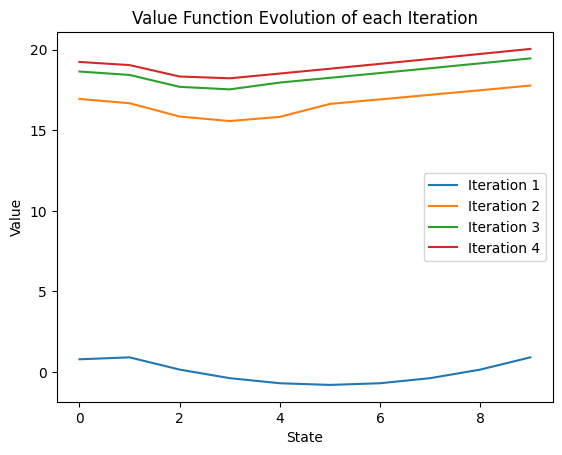

In [867]:
states = np.arange(0, mdpc.n_states)
for i, V in enumerate(value_functions_pi):
    plt.plot(states, V, label=f'Iteration {i+1}')

# Plot the value function for the each state
plt.xlabel('State')
plt.ylabel('Value')
plt.title(f'Value Function Evolution of each Iteration')
plt.legend()
plt.show()

**b.3**) Implement the `value_iteration` algorithm, where you skip the policy improvement steps until you reach the
optimal value function, from which a final policy can be computed.

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{0} {\longrightarrow} v_{1} {\longrightarrow} v_{2}
{\longrightarrow} \cdots {\longrightarrow} v_{*} \rightarrow \pi_{*}$$

Note: this should be implemented as a function which starts with an all-zeros value function $v_{0}=0 \
\forall s \in \mathcal{S}$ and returns a final (optimal) policy and a sequence of value functions. To construct the
final policy, you will also need a function to construct a policy based on a state value function (this is provided below for simplicity).
Run your *value iteration* algorithm starting with the stochastic uniform policy, print
 the resulting policy and plot the evolution of the value functions. ---------(**0.6 point**)

In [868]:
def policy_construction(mdp, V):
	"""
	Derive policy from value function
	"""
	policy = np.ones([mdp.n_states, mdp.n_actions]) / mdp.n_actions
	for s in range(mdp.n_states):
		a_values = np.zeros(mdp.n_actions)
		for a in range(mdp.n_actions):
			a_values[a] = sum(mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma * V[s1])
			                       for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
		best_a = np.argmax(a_values)
		# Update Policy
		policy[s, :] = 0
		policy[s, best_a] = 1
	return policy

In [869]:
def value_iteration(mdp, theta=1e-8, max_t=float('inf')):
    """
    returns policy and list of value estimates per state
    """
    start = time.time()
    V = np.zeros(mdp.n_states)
    policy = uniform_stochastic_policy(mdp.n_states, mdp.n_actions)

    # Evaluate policy iteratively
    t = 0
    Vs = []

    while True:
        # Early stopping condition
        delta = 0
            # Update each state
        for s in range(mdp.n_states):
            # Do a one-step lookahead to calculate state-action values
            a_values = one_step_lookahead(mdp, s, V, policy)
            # Select best action to perform based on the highest state-action value
            best_a_val = np.max(a_values)
            # Calculate change in value
            delta = max(delta, np.abs(V[s] - best_a_val))
            # Update the value function for current state
            V[s] = best_a_val
        Vs.append(copy.copy(V)) 

        # Check if we can stop
        if t > max_t or delta < theta:
            print(f'Value-iteration converged at iteration #{t}.')
            break
        t += 1

    # Output deterministic policy
    policy = policy_construction(mdp, V)
    end = time.time()
    print("{0} iterations completed in {1} ms".format(len(Vs), end-start))
    return policy, Vs, end - start

In [870]:
optimized_policy_vi, value_functions_vi, timings_vi = value_iteration(mdpc)
mdpc.print_policy(optimized_policy_vi)

Value-iteration converged at iteration #913.
914 iterations completed in 0.9099392890930176 ms
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


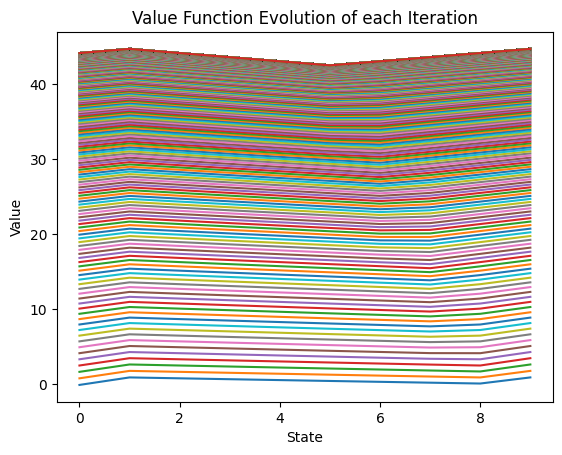

In [871]:
states = np.arange(mdpc.n_states)
for i, V in enumerate(value_functions_vi):
    plt.plot(states, V, label=f'Iteration {i+1}')
plt.xlabel('State')
plt.ylabel('Value')
plt.title(f'Value Function Evolution of each Iteration')
plt.show()

Given that we know the ground truth for this simple problem, we can evaluate the performance of the
different algorithms by measuring how far they are from the optimal solution. So, we can calculate the Mean Squared
Error (MSE) and plot it as a function of time to see how fast and accurate are the different algorithms. **Note:** In
 this initial example, we will provide a base implementation, but this procedure will be repeated to
 evaluate the different classes of solutions (here, the MSE is plotted as a function of computing time, but in the
 model-free algorithms it will be plotted as a function of the number of episodes used).

  ***Notice:*** This is not a question.

In [872]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# time_axis_pi = np.arange(0, timings_pi, timings_pi / (len(value_functions_pi)+1))[:len(value_functions_pi)]
# ax[0].plot(time_axis_pi, list(map(lambda x: np.mean((x - V_c)**2), value_functions_pi)), '-o', label='policy iteration')
# time_axis_vi = np.arange(0, timings_vi, timings_vi / (len(value_functions_vi)+1))[:len(value_functions_vi)]
# ax[0].plot(time_axis_vi, list(map(lambda x: np.mean((x - V_c)**2), value_functions_vi)), '-x', label='value iteration')
# ax[0].set_xlabel('Time [ms]')
# ax[0].set_ylabel('MSE')
# ax[0].set_title('State value')

# ax[1].plot(time_axis_pi, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_pi)),
#            '-o', label='policy iteration')
# ax[1].plot(time_axis_vi, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_vi)),
#            '-o', label='value iteration')
# ax[1].set_xlabel('Time [ms]')
# ax[1].set_ylabel('MSE')
# ax[1].set_title('Q-value')
# plt.legend()

# print("Policy MSE: {} (policy iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_pi))**2))
# print("Policy MSE: {} (value iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_vi))**2))

### 3. Monte Carlo Methods *(2 points)*

For this exercise, we will use the *episodic* version of the MDP (`mdpe` instantiated above).

In [873]:
# Some plot structures are used here and in sub-assignment 4, to avoid repetition, I made them into a function

def plot_comparison_Qs_or_Vs(Qs_or_Vs: str, Qs_Vs):
    """
    Plots the MSE of multiple iterations of value or q-value function of each state (Vs or Qs) with the optimal ones
    mdpe used
	Qs_or_Vs: 'Qs' if q-values functions or 'Vs' if value functions given
    """
    optimal_V = policy_evaluation(mdpe, mdpe.optimal_policy())

    mse_list = []
    if Qs_or_Vs == 'Qs':
        optimal_Q = mdpe.v_to_q(optimal_V)
        for Q_sim in Qs_Vs:
            squared_differences = [(optimal_Q[state][action] - Q_sim[state][action])**2 for state in range(len(Q_sim)) for action in range(len(Q_sim[state]))]
            mse = sum(squared_differences) / len(Q_sim)
            mse_list.append(mse)
    elif Qs_or_Vs == 'Vs':
        for V_sim in Qs_Vs:
            squared_differences = [(optimal_V[state] - state_value)**2 for state, state_value in enumerate(V_sim)]
            mse = sum(squared_differences) / len(V_sim)
            mse_list.append(mse)
    else:
        print('No Qs or Vs specified for Qs_or_Vs')

    simulations = np.arange(0, len(Qs_Vs))

    plt.plot(simulations, mse_list, marker='o', linestyle='-')
    plt.title('MSE for each Iteration of MDPE')
    plt.xlabel('Simulations')
    plt.ylabel('Mean Squared Error')
    plt.show()

**a**) Why do we need to use an *episodic* task? ---------(**0.2 point**)

Because we need well-defined episodes to make the value functions of the MC methods converge.<br>
In continuous tasks, defining episode boundaries becomes challenging. Without clear episode boundaries, it may be difficult to determine when to update value functions, leading to slower convergence or even divergence. 

**b**) **MC Prediction**: Implement an *on-policy, first-visit MC* algorithm to estimate the state-value function for
the optimal policy
. This should be provided as a function `mc_prediction` that takes in the initial policy and
 a parameter specifying how many sample episodes to run. Use your implementation to calculate the approximate state
 value function $V_{\pi}$ for the optimal policy $\pi_{*}$. Plot the MSE between the estimated value function and the
  true optimal $v_{*}$ as a function of number of episodes, i.e. how the accuracy of the estimate evolves across
  episodes. ---------(**0.9 point**)

In [874]:
def mc_prediction(mdp, policy, num_simulations=30):
	# Conditions for convergence
	assert(mdp.task == 'episodic')
	V = np.zeros(mdp.n_states)
	Vs = []

	for _ in range(num_simulations):
		episode = mdp.sample_episode(policy)
		rev_episode = episode[::-1]

		# keep track of the first visits
		first_visits_rev = [(False, -1) for _ in range(len(rev_episode))]
		for rev_episode_index, (s, _, _) in enumerate(rev_episode):
			if not (True, s) in first_visits_rev:
				first_visits_rev[rev_episode_index] = (True, s)
		G = 0
		state_returns = []
		state_counter = mdp.n_states

		#starting at last timestep
		for rev_seq_index, (s, _, r) in enumerate(rev_episode):
			G = mdp.gamma * G + r
			if first_visits_rev[rev_seq_index][1]:
				state_returns.append(G)
				V[s] = sum(state_returns) / len(state_returns)
				state_counter -= 1
			if state_counter <= 0:
				break

		Vs.append(copy.copy(V))
				
	return V, Vs

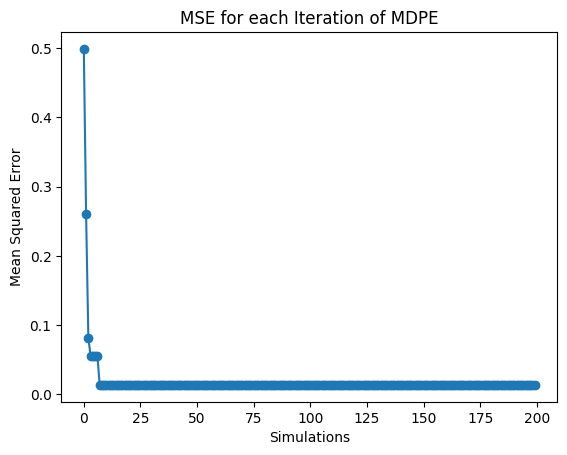

In [875]:
V, Vs = mc_prediction(mdpe, mdpe.optimal_policy(), num_simulations=200)
plot_comparison_Qs_or_Vs('Vs', Vs)

**c**) **MC Control**: Implement an *on-policy, first-visit MC* algorithm to optimize the policy. To do this, you will
need to
estimate the Q-value function (computing returns after first visit to state-action pairs) and use it to take an
$\epsilon$-greedy action selection to gradually improve the policy. This should be provided as a function
`mc_control` that takes in the initial policy, the number of episodes to use and `epsilon` to set the mininum action
probability. Run for 200 episodes and plot the MSE between the estimated q-value function and the
  true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`. ---------(**0.9 point**)

In [876]:
def mc_control(mdp, policy, num_simulations=30, epsilon=0.01):
	"""
	Run the Monte Carlo First Visit On-Policy algorithm and return the estimated
	policy, Q (state action) values, and returns (rewards) dict.
	Uses epsilon-soft policies instead of exploring starts
	:param mdp:
	:param policy: any epsilon soft policy; e.g. mdp.uniform_stochastic_policy()
	:param num_simulations : int Number of episodes for the policy iteration process
	:param epsilon: epsilon-soft minimum probability

	:return policy: numpy.ndarray Estimated Policy
	:return Q: numpy.ndarray Estimated Q (state-action) values
	:return R: dict Returns obtained for every state
	"""
	# Conditions for convergence
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])
	Qs = []

	for _ in range(num_simulations):
		episode = mdp.sample_episode(policy)
		rev_episode = episode[::-1]
		first_visit_rev = [(False, -1, -1) for _ in range(len(rev_episode))]
		for rev_episode_index, (s, a, _) in enumerate(rev_episode):
			if (True, s, a) not in first_visit_rev:
				first_visit_rev[rev_episode_index] = (True, s, a)

		G = 0
		state_action_returns = [[[] for _ in range(mdp.n_actions)] for _ in range(mdp.n_states)] #3D array: state_action_returns[state][action][returns]
		#starting at last timestep
		for rev_seq_index, (s, _, r) in enumerate(rev_episode):
			G = mdp.gamma * G + r
			if first_visit_rev[rev_seq_index] == (True, _, _):
				state_action_returns[s][a].append(G)
				Q[s][a] = sum(state_action_returns[s][a]) / len(state_action_returns[s][a])
				A_star = np.argmax(Q[s])
				for a in range(mdp.n_actions): 
					if (a == A_star):
						policy[s][a] = 1 - epsilon + (epsilon / mdp.n_actions)
					else:
						policy[s][a] = epsilon / mdp.n_actions
		Qs.append(copy.copy(Q))

	return policy, Qs

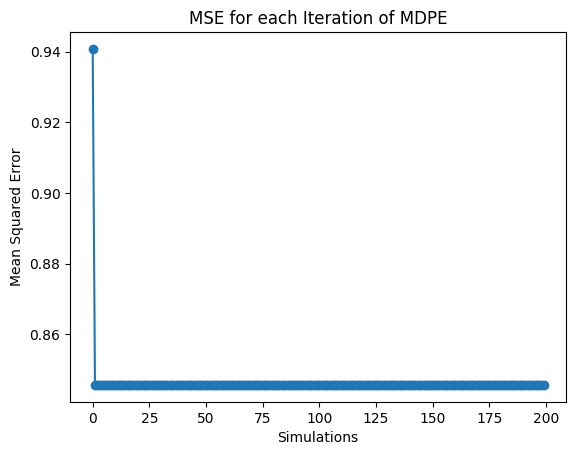

In [889]:
policy, Qs = mc_control(mdpe, uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions), num_simulations=200)
plot_comparison_Qs_or_Vs('Qs', Qs)

---

### 4. TD-methods *(3 points)*

Note that, despite the fact that TD-learning can handle continuing tasks, we will constrain the study to episodic
tasks because the nature of the environment would result in infinite loops where no stable solutions can be found.


**a**) **TD Prediction**: Implement and run TD(0) to estimate the value function under the optimal policy. Run the
algorithm for 500 sample episodes with a fixed $\alpha=0.01$. Plot the result as the MSE between the state
 value estimates $V$ and the ground truth $v_{\pi}$ as a function of number of episodes, i.e. how
 the accuracy of the estimate evolves across
  episodes. ---------(**1 point**)

In [878]:
def td0_prediction(mdp, policy, num_simulations=30, alpha = 0.01):
	"""
	TD(0) prediction algorithm
	:param mdp:
	:param policy:
	:param num_simulations: number of episodes to sample
	:param alpha: fixed learning rate
	:return:
	"""
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')
	V = np.zeros(mdp.n_states)
	Vs = []

	for _ in range(num_simulations):
		s = mdp.reset()
		while not mdp.is_terminal(s):
			a = mdp.sample_action(s, policy)
			s1, r_index = mdp.step(s, a)
			V[s] += alpha * (mdp.reward[r_index] + mdp.gamma * V[s1] - V[s])
			s = s1
		Vs.append(copy.copy(V))
	return V, Vs

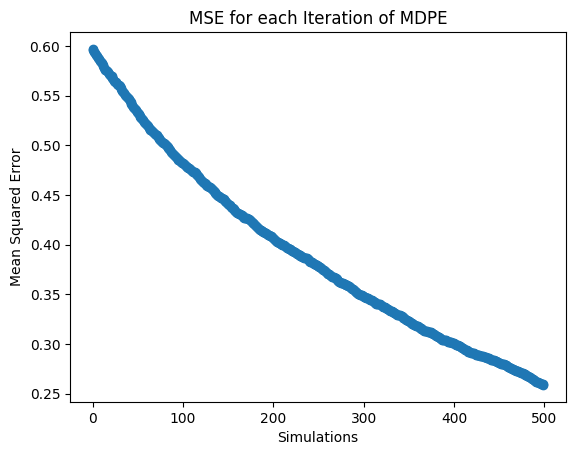

In [879]:
td_v, td_vs = td0_prediction(mdpe, mdpe.optimal_policy(), num_simulations=500, alpha=0.01)
plot_comparison_Qs_or_Vs('Vs', td_vs)

**b**) **On-policy TD control**: Implement and run the SARSA algorithm to estimate the optimal policy. Remember
that policy updates are $\epsilon$-greedy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`. ---------(**1 point**)

In [880]:
def epsilon_greedy_action(Q_state, epsilon):
    """
    Choose action using epsilon-greedy policy
    :param Q_values: Q-values for current state
    :param epsilon: exploration probability
    :return: action
    """
    if np.random.random() < epsilon:
        return np.random.randint(len(Q_state))  # random action
    else:
        return np.argmax(Q_state)  # greedy action
    
def determine_policy_from_Q(mdp, Q):
    for state in mdp.terminal_states():
        policy[state,:] = 1.0 / mdp.n_actions
    for state in mdp.nonterminal_states():
        a_max = np.random.choice(np.flatnonzero(Q[state] == np.max(Q[state])))
        policy[state, a_max] = 1.0
    return policy

def sarsa(mdp, num_simulations=30, alpha=0.01, epsilon=0.1):
    """
    SARSA on-policy control
    :param mdp:
    :param num_simulations: number of sample episodes
    :param alpha: learning rate
    :param epsilon: minimum action selection probability
    :return:
    """
    # Conditions for convergence; note that we can also run on continuing problems
    assert (mdp.task == 'episodic')
    Q = np.zeros([mdp.n_states, mdp.n_actions])
    policy = uniform_stochastic_policy(mdp.n_states, mdp.n_actions)
    Qs = []
      
    for _ in range(num_simulations):
        s = mdp.reset()
        a = epsilon_greedy_action(Q[s], epsilon)
            
        while not mdp.is_terminal(s):
            s1, reward_index = mdp.step(s, a)
            a1 = epsilon_greedy_action(Q[s1], epsilon)
            Q[s][a] += alpha * (mdp.reward[reward_index] + mdp.gamma * Q[s1][a1] - Q[s][a])
            s = s1
            a = a1

        Qs.append(copy.copy(Q))
    
    policy = determine_policy_from_Q(mdp, Q)
    return policy, Q, Qs

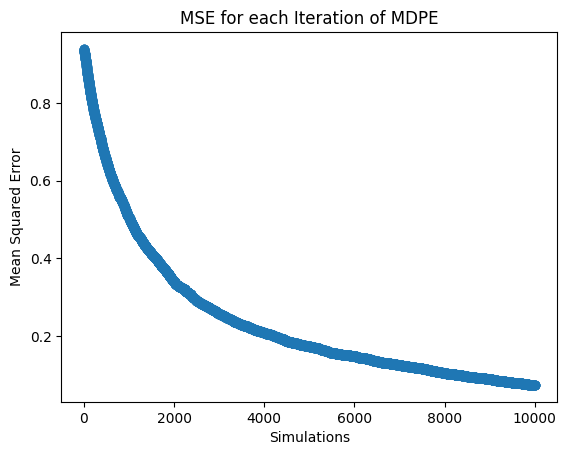

In [881]:
policy_sarsa, Q, Qs = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)
plot_comparison_Qs_or_Vs('Qs', Qs)

**c**) **Off-policy TD control**: Implement and run the Q-learning algorithm to estimate the optimal policy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes. ---------(**1 point**)

In [882]:
def qlearning(mdp, behavioral_policy, num_simulations=30, alpha=0.01, epsilon=0.1):
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])
	Qs = []


	for _ in range(num_simulations):
		s = mdp.reset()
		while not mdp.is_terminal(s):
			a = mdp.sample_action(s, behavioral_policy) 
			(s1, r) = mdp.step(s, a)
			max_q_next = np.max(Q[s1])
			Q[s][a] += alpha * (mdp.reward[r] + mdp.gamma * max_q_next - Q[s][a])
			s = s1

		Qs.append(copy.copy(Q))

	target_policy = determine_policy_from_Q(mdpe, behavioral_policy)
	return target_policy, Q, Qs

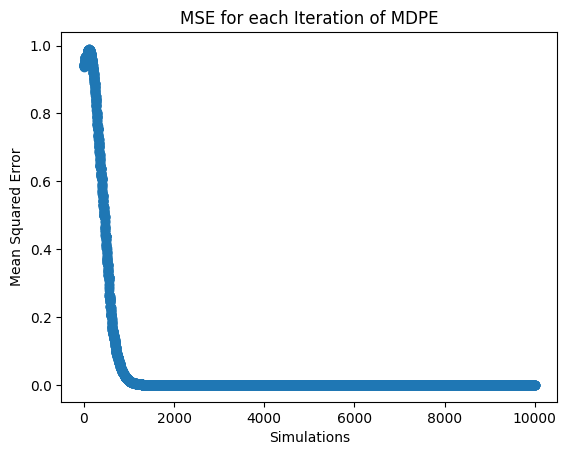

In [883]:
b_policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_Q, Q, Qs = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=10000, alpha=0.01)
plot_comparison_Qs_or_Vs('Qs', Qs)

---

### 5. Comparing tabular methods *(2 bonus points)*

Now that you have all algorithms implemented, change the task to include a finer grid on the circle world. Create a
CircleWorld environment with a larger number of states and re-run the control algorithms. Plot the results side-by-side
 to directly
compare.

In [884]:
mdp_many_states = CircleWorld(n_states=50, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1., state_labels=None, action_labels=['L', 'R'])

def make_mse_list(Qs, mdp, optimal_V):
    mse_list = []
    optimal_Q = mdp.v_to_q(optimal_V)
    for Q_sim in Qs:
        squared_differences = [(optimal_Q[state][action] - Q_sim[state][action])**2 for state in range(len(Q_sim)) for action in range(len(Q_sim[state]))]
        mse = sum(squared_differences) / len(Q_sim)
        mse_list.append(mse)
    return mse_list
    

def plot_side_to_side_compare(Qs_1, mdp_1, Qs_2, mdp_2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    optimal_V_1 = policy_evaluation(mdp_1, mdp_1.optimal_policy())
    optimal_V_2 = policy_evaluation(mdp_2, mdp_2.optimal_policy())
    mse_list_1 = make_mse_list(Qs_1, mdp_1, optimal_V_1)
    mse_list_2 = make_mse_list(Qs_2, mdp_2, optimal_V_2)

    axs[0].plot(np.arange(0, len(Qs_1)), mse_list_1, marker='o', linestyle='-')
    axs[0].set_title('MSE for each Iteration of a MDP with ' + str(mdp_1.n_states))
    axs[0].set_xlabel('Simulations')
    axs[0].set_ylabel('Mean Squared Error')

    axs[1].plot(np.arange(0, len(Qs_2)), mse_list_2, marker='o', linestyle='-')
    axs[1].set_title('MSE for each Iteration of a MDP with ' + str(mdp_2.n_states))
    axs[1].set_xlabel('Simulations')
    axs[1].set_ylabel('Mean Squared Error')

    plt.tight_layout()  # prevent overlap
    plt.show()

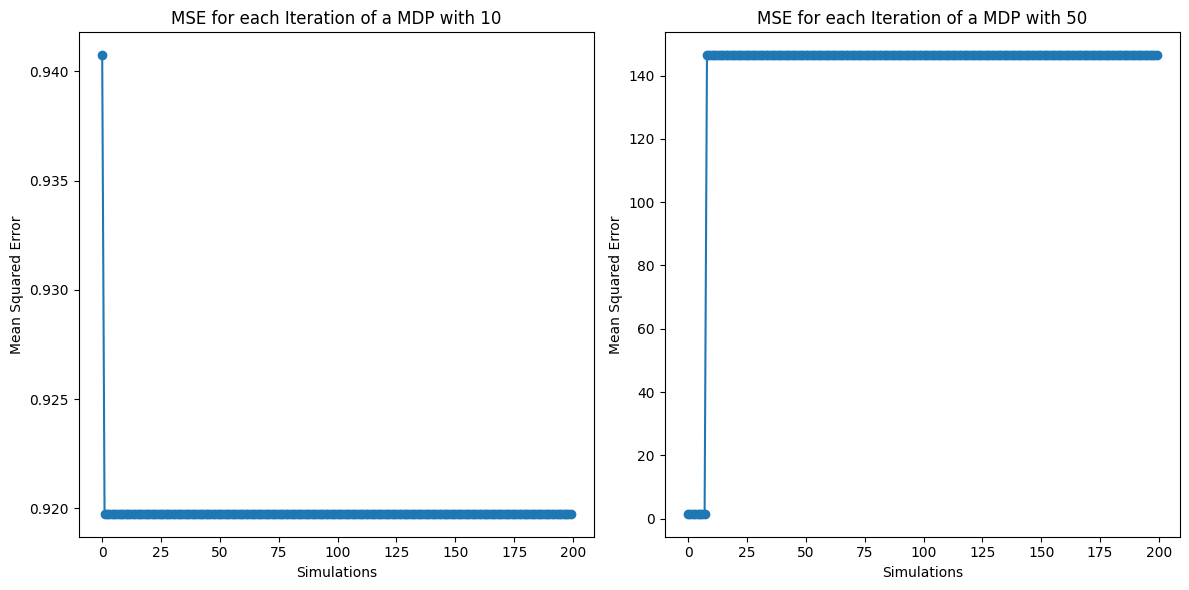

In [885]:
# MC control
policy_mdpe, Qs_mdpe = mc_control(mdpe, uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions), num_simulations=200)
policy_mdp_many_s, Qs_many_s = mc_control(mdp_many_states, uniform_stochastic_policy(mdp_many_states.n_states, mdp_many_states.n_actions), num_simulations=200)
plot_side_to_side_compare(Qs_mdpe, mdpe, Qs_many_s, mdp_many_states)

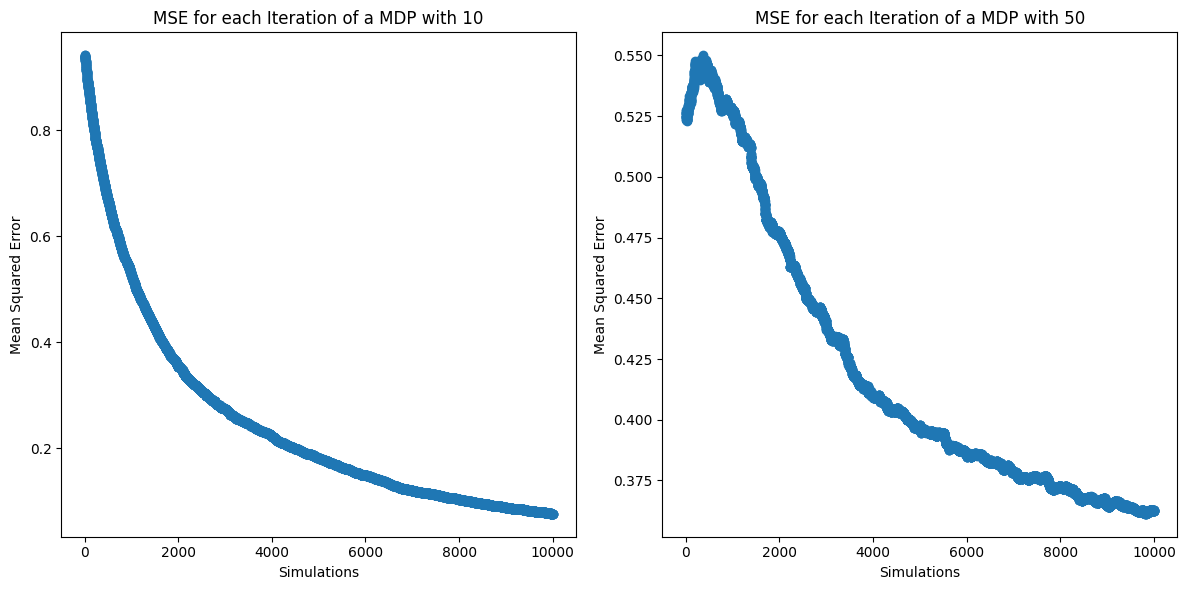

In [890]:
# on-policy TD control
policy_sarsa_mdpe, Qe, Qs_mdpe = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)
policy_sarsa_mdp_many_s, Q_many_s, Qs_many_s = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)
plot_side_to_side_compare(Qs_mdpe, mdpe, Qs_many_s, mdp_many_states)

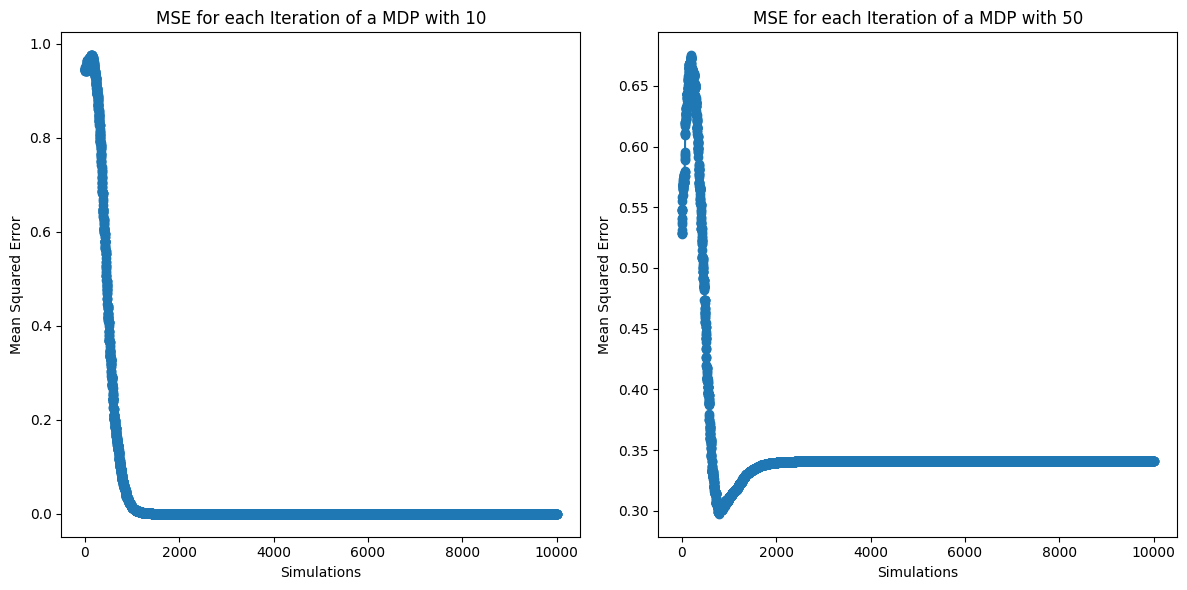

In [891]:
# off-policy TD control
b_policy_mdpe = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_Qe, Qe, Qs_mdpe = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=10000, alpha=0.01)
b_policy_mdp_many_s = uniform_stochastic_policy(mdp_many_states.n_states, mdp_many_states.n_actions)
policy_Q_many_s, Q_many_s, Qs_many_s = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=10000, alpha=0.01)
plot_side_to_side_compare(Qs_mdpe, mdpe, Qs_many_s, mdp_many_states)